# Kickstarter Projects Analysis  

In here, all analysis will take place, as well as explanations.

In [0]:
# Import required libraries for analysis

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import sklearn
import numpy as np
from pyspark.sql.functions import col, sum

## Step 1 - Data Loading and Inspection  

To start with, it's important to first check the table, get information on each column and see it's breakdown and to get an idea of the depth of the data we have to work with.

In [0]:
df = spark.read.csv('/Volumes/workspace/default/de_data/kickstarter_projects.csv', header=True, inferSchema=True)

When printing schema, you can see that the data is in raw format. First steps must be to format the columns based on the data they hold.

In [0]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Subcategory: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Launched: string (nullable = true)
 |-- Deadline: string (nullable = true)
 |-- Goal: string (nullable = true)
 |-- Pledged: string (nullable = true)
 |-- Backers: string (nullable = true)
 |-- State: string (nullable = true)



In [0]:
df = df.withColumn('ID', df['ID'].try_cast('int'))

df = df.withColumn('Launched', df['Launched'].try_cast('timestamp'))

df = df.withColumn('Deadline', df['Deadline'].try_cast('timestamp'))

df = df.withColumn('Goal', df['Goal'].try_cast('int'))

df = df.withColumn('Pledged', df['Pledged'].try_cast('int'))

df = df.withColumn('Backers', df['Backers'].try_cast('int'))

We have quite a few null values now we've used _tryCast()_, but still the max we have is 1,290, and with a database of over 10,000 rows, I feel safe to remove these and still achieve good analysis.

In [0]:
df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns]).collect()

[Row(ID=0, Name=0, Category=0, Subcategory=3, Country=4, Launched=1290, Deadline=210, Goal=1290, Pledged=210, Backers=27, State=5)]

In [0]:
df = df.dropna()

In [0]:
df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns]).collect()

[Row(ID=0, Name=0, Category=0, Subcategory=0, Country=0, Launched=0, Deadline=0, Goal=0, Pledged=0, Backers=0, State=0)]

Now with no NULL values in our dataset, we can continue formatting.  
  
Later on in my analysis, I want to assign a column to flag in greater detail how well (or bad) a project performed. In this case, it's worth discussing how we can show that. I want to be able to see if a project failed, first of all. But _how badly_ it failed I also want to know, so I will assign it the following.

![](https://github.com/joezed/de-kickstarter-projects/blob/main/assets/state_decision_tree.png?raw=true)

In [0]:
df = df.toPandas()

In [0]:
df['Pledged'] = pd.to_numeric(df['Pledged'], errors='coerce').fillna(0)
df['Goal'] = pd.to_numeric(df['Goal'], errors='coerce').fillna(0)

conditions = [
    (df['Pledged'] > df['Goal'] * 2),                               # Condition 1
    (df['Pledged'] > df['Goal'] * 1.5),                             # Condition 2
    (df['Pledged'] >= df['Goal']),                                  # Condition 3
    ((df['Pledged'] < df['Goal']) & (df['Pledged'] > 0)),           # Condition 4
    (df['Pledged'] == 0)                                            # Condition 5
]

choices = [2, 1, 0, -1, -2]

df['state_flag'] = np.select(conditions, choices, default=0)

Now time to test my logic has worked. I've identified the following ID's with different states:

| ID | Pledged | Goal | Condition Met | Expected Result |
| :--- | :--- | :--- | :--- | :--- |
| 177921463 | 1820 | 500 | Pledged > 2x Goal (Condition 1) | 2 |
| 515267366 | 2265 | 1500 | Pledged > 1.5x Goal (Condition 2) | 1 |
| 789689637 | 10164 | 10000 | Pledged > Goal (Condition 3) | 0 |
| 755288436 | 360 | 360 | Pledged = Goal (Condition 3) | 0 |
| 830477146 | 41 | 200 | Pledged < Goal (Condition 4) | -1 |
| 1502297238 | 0 | 500 | 0 Pledged (Condition 5) | -2 |

In [0]:
ids = [177921463, 515267366, 789689637, 755288436, 830477146, 1502297238]

df.loc[df['ID'].isin(ids)]

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,state_flag
6,830477146,Web Site for Short Horror Film,Film & Video,Shorts,United States,2009-04-29 02:04:21,2009-05-29,200,41,3,Failed,-1
8,1502297238,Produce a Play (Canceled),Theater,Theater,United States,2009-04-29 04:37:37,2009-06-01,500,0,0,Canceled,-2
11,515267366,Crossword Puzzles!,Games,Puzzles,United States,2009-04-29 13:52:03,2009-06-30,1500,2265,163,Successful,1
13,177921463,Icons for your iPhone apps,Technology,Software,United States,2009-04-29 23:11:15,2009-06-15,500,1820,98,Successful,2
94,755288436,Help me get equipment and I'll make a song for...,Music,Music,United States,2009-06-01 03:37:06,2009-07-15,360,360,14,Successful,0
4428,789689637,The Four-Week Feature Film: Where Creativity M...,Film & Video,Narrative Film,United States,2010-06-14 08:44:16,2010-07-24,10000,10164,131,Successful,0


## Step 2 - Analysis

Now I have a formatted table, with correct data types and a state_flag for future analysis, I can start asking the questions and finding out some answers.

### How many projects actually succeed?

A simple first question really - how many projects actually succeed on Kickstarter. My guess is not actually that many, but they'll be factors as to why, which I'll explore further later. Let's found out that one first. We're removing Live and Suspended projects for now. Live is, obviously, currently running Kickstarter projects, or at least at the time this data was taken, but Suspended, I actually didn't know why. Kickstarter says this... 
> A project may be suspended if our Trust & Safety team uncovers evidence that it is in violation of Kickstarter's rules, including but not limited to: Misrepresentation of support, through self-pledging or artificial inflation of the number of backers or amounts pledged.  

... so actually, I don't really care for analysing them.

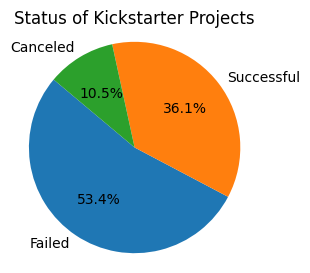

In [0]:
q1_desired_states = ['Successful', 'Failed', 'Canceled']

q1_filtered_df = df[df['State'].isin(q1_desired_states)]

q1_state_counts = q1_filtered_df['State'].value_counts()

plt.figure(figsize=(3, 3))

plt.pie(q1_state_counts, labels=q1_state_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Status of Kickstarter Projects', fontsize=12)

plt.axis('equal')  

plt.show()

I assumed correctly, but wasn't expecting how low it was - only 36.1% make it to funding. 

It's worth mentioning though that some Kickstarter projects _only just_ fail, but they'll still come as a fail. But that's how Kickstarter works. You want \$1000 and only make \$999? To them, that project failed, and **nothing** is funded. Brutal.

### Of the failures, how many were close?

This is the brutal question I guess, but my morbid curiosity wants to know. How many got $1 off the fateful funding? I'll apply a percentage to this of all the failures, and how far off they were based on a percentage.

In [0]:
q2_filtered_df = df[df['State'] == 'Failed'].copy()

q2_filtered_df['funding_percentage'] = ((q2_filtered_df['Pledged'] / q2_filtered_df['Goal']) * 100).round(0)

This will be hard to read - let's add some ranges of funding.

In [0]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

q2_filtered_df['funding_range'] = pd.cut(q2_filtered_df['funding_percentage'], bins=bins, labels=labels, right=False)

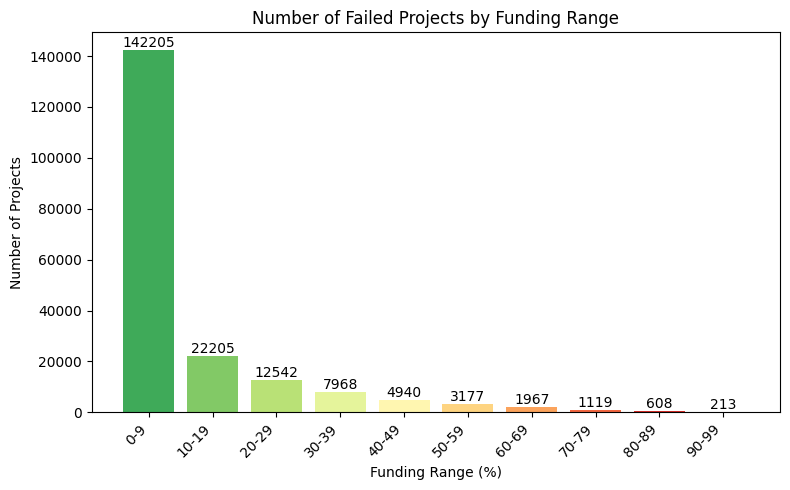

In [0]:
range_counts = q2_filtered_df['funding_range'].value_counts().sort_index()

num_bars = len(range_counts)
colors = cm.RdYlGn_r(np.linspace(0.15, 1, num_bars))

plt.figure(figsize=(8, 5))
bars = plt.bar(range_counts.index, range_counts.values, color=colors)

plt.xlabel('Funding Range (%)')
plt.ylabel('Number of Projects')
plt.title('Number of Failed Projects by Funding Range')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

Ouch, so those 213 were SO close. And there's some that were ridiculously close, like Citizens of the Planet - Live Experience, only \$837 off after nearly \$10,000 raised. That's gotta sting. 

In [0]:
display(q2_filtered_df.loc[q2_filtered_df['ID'] == 865653284])

ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,state_flag,funding_percentage,funding_range
865653284,Citizens of the Planet - Live Experience,Music,Music,United States,2013-02-08T01:55:14.000Z,2013-03-10T00:00:00.000Z,100000,99136,592,Failed,-1,99.0,90-99
